Loading datasets...
Fraud Data shape: (151112, 11)
IP Country shape: (138846, 3)
Fraud Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB
None

First 5 rows:
   user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-

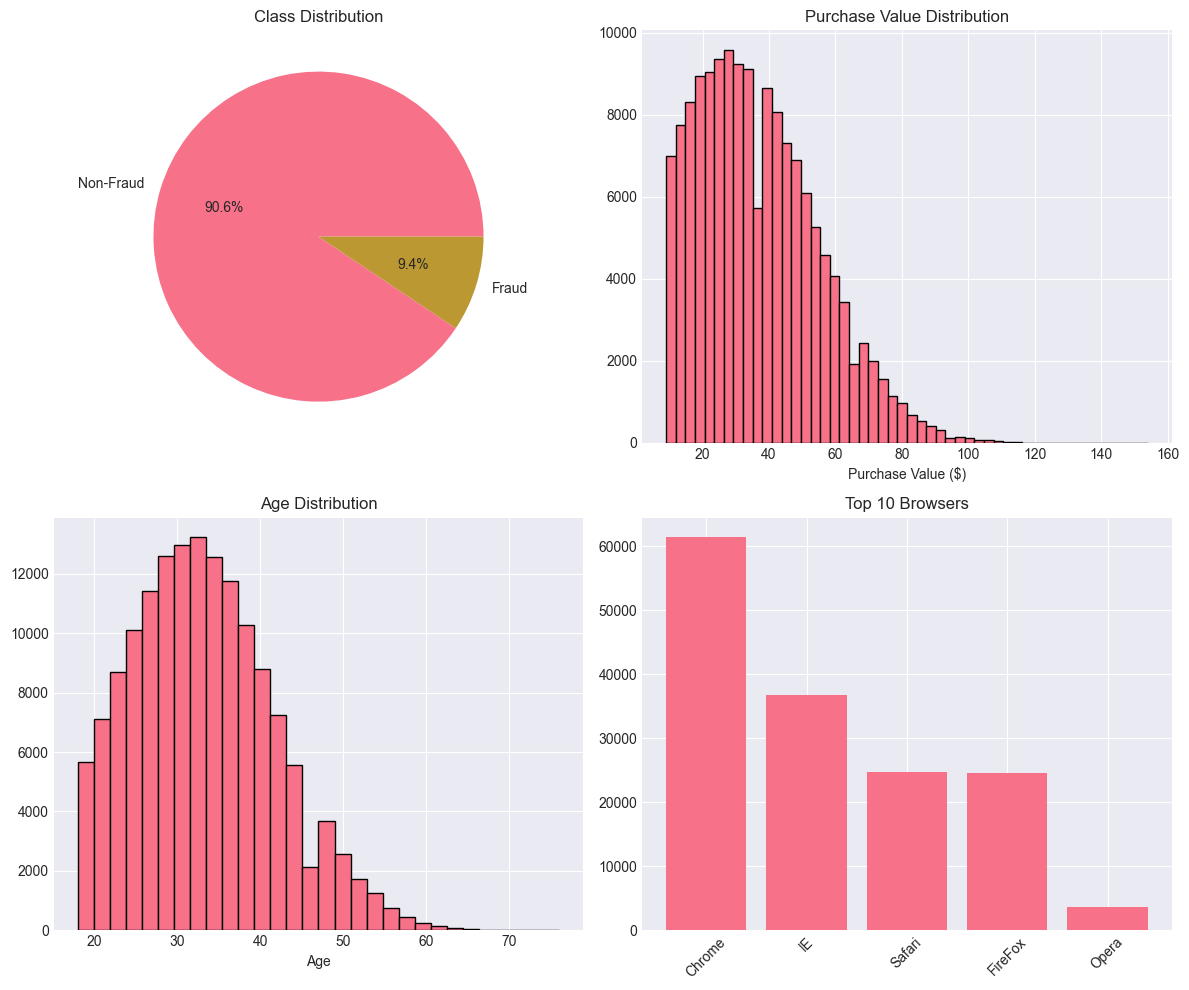

In [3]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Cell 2: Load data
print("Loading datasets...")
fraud_data = pd.read_csv('../data/raw/Fraud_Data.csv')
ip_country = pd.read_csv('../data/raw/IpAddress_to_Country.csv')

print(f"Fraud Data shape: {fraud_data.shape}")
print(f"IP Country shape: {ip_country.shape}")

# Cell 3: Basic info
print("Fraud Data Info:")
print(fraud_data.info())
print("\nFirst 5 rows:")
print(fraud_data.head())

# Cell 4: Check for missing values
print("Missing values in Fraud Data:")
print(fraud_data.isnull().sum())

# Cell 5: Check class distribution
print("Class Distribution (Target Variable):")
print(fraud_data['class'].value_counts())
print(f"\nFraud percentage: {fraud_data['class'].mean()*100:.2f}%")

# Cell 6: Convert time columns
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

# Cell 7: Basic visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Class distribution
axes[0,0].pie(fraud_data['class'].value_counts(), 
              labels=['Non-Fraud', 'Fraud'], 
              autopct='%1.1f%%')
axes[0,0].set_title('Class Distribution')

# Purchase value distribution
axes[0,1].hist(fraud_data['purchase_value'], bins=50, edgecolor='black')
axes[0,1].set_title('Purchase Value Distribution')
axes[0,1].set_xlabel('Purchase Value ($)')

# Age distribution
axes[1,0].hist(fraud_data['age'], bins=30, edgecolor='black')
axes[1,0].set_title('Age Distribution')
axes[1,0].set_xlabel('Age')

# Browser distribution
browser_counts = fraud_data['browser'].value_counts().head(10)
axes[1,1].bar(browser_counts.index, browser_counts.values)
axes[1,1].set_title('Top 10 Browsers')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [4]:
# Cell 2  Check and remove duplicates
print("Checking for duplicates...")
duplicate_count = fraud_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    fraud_data = fraud_data.drop_duplicates()
    print(f"Removed duplicates. New shape: {fraud_data.shape}")
else:
    print("No duplicates found.")

Checking for duplicates...
Number of duplicate rows: 0
No duplicates found.


In [5]:
# Cell 3: Fix IP address data type
print("\nFixing IP address data type...")
print(f"Current IP address dtype: {fraud_data['ip_address'].dtype}")

# Convert from float to integer for geolocation lookup
fraud_data['ip_address'] = fraud_data['ip_address'].astype('int64')
print(f"Fixed IP address dtype: {fraud_data['ip_address'].dtype}")


Fixing IP address data type...
Current IP address dtype: float64
Fixed IP address dtype: int64


In [6]:
# Cell 4: Create time-based features (REQUIRED by Task 1)
print("\nCreating time-based features...")

# 1. hour_of_day (from purchase_time)
fraud_data['hour_of_day'] = fraud_data['purchase_time'].dt.hour

# 2. day_of_week (0=Monday, 6=Sunday)
fraud_data['day_of_week'] = fraud_data['purchase_time'].dt.dayofweek

# 3. time_since_signup (hours between signup and purchase)
fraud_data['time_since_signup'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds() / 3600

print("Created features: hour_of_day, day_of_week, time_since_signup")
print(fraud_data[['hour_of_day', 'day_of_week', 'time_since_signup']].head())


Creating time-based features...
Created features: hour_of_day, day_of_week, time_since_signup
   hour_of_day  day_of_week  time_since_signup
0            2            5        1251.856111
1            1            0           4.984444
2           18            3           0.000278
3           13            0         136.690278
4           18            2        1211.516944


In [7]:
# Cell 5 Create transaction frequency feature (REQUIRED by Task 1)
print("\nCreating transaction frequency feature...")

# Count how many transactions each user has
user_transaction_count = fraud_data['user_id'].value_counts()
fraud_data['user_transaction_count'] = fraud_data['user_id'].map(user_transaction_count)

print(f"User with most transactions: {fraud_data['user_transaction_count'].max()}")
print(f"Average transactions per user: {fraud_data['user_transaction_count'].mean():.2f}")


Creating transaction frequency feature...
User with most transactions: 1
Average transactions per user: 1.00


In [8]:
# Cell 6  Quick analysis of new features
print("\n=== ANALYSIS OF NEW FEATURES ===")

# 1. Fraud by hour of day
fraud_by_hour = fraud_data.groupby('hour_of_day')['class'].mean() * 100
print("\n1. Fraud rate by hour of day (top 3):")
print(fraud_by_hour.sort_values(ascending=False).head(3))

# 2. Fraud by time since signup
print("\n2. Fraud by time since signup:")
print(f"Fraud within 1 hour of signup: {fraud_data[fraud_data['time_since_signup'] < 1]['class'].mean()*100:.2f}%")
print(f"Fraud after 24 hours: {fraud_data[fraud_data['time_since_signup'] > 24]['class'].mean()*100:.2f}%")

# 3. Transaction frequency vs fraud
print("\n3. Transaction frequency vs fraud:")
single_trans = fraud_data[fraud_data['user_transaction_count'] == 1]['class'].mean() * 100
multi_trans = fraud_data[fraud_data['user_transaction_count'] > 1]['class'].mean() * 100
print(f"Single transaction users: {single_trans:.2f}% fraud")
print(f"Multiple transaction users: {multi_trans:.2f}% fraud")


=== ANALYSIS OF NEW FEATURES ===

1. Fraud rate by hour of day (top 3):
hour_of_day
17    10.748531
9     10.579620
8     10.145608
Name: class, dtype: float64

2. Fraud by time since signup:
Fraud within 1 hour of signup: 99.52%
Fraud after 24 hours: 4.57%

3. Transaction frequency vs fraud:
Single transaction users: 9.36% fraud
Multiple transaction users: nan% fraud


In [9]:
# Cell 7: Save the cleaned and engineered data
print("\nSaving cleaned data...")
fraud_data.to_csv('../data/processed/fraud_data_cleaned_with_features.csv', index=False)
print("✅ Saved to: data/processed/fraud_data_cleaned_with_features.csv")
print(f"Final dataset shape: {fraud_data.shape}")
print(f"Columns: {list(fraud_data.columns)}")


Saving cleaned data...
✅ Saved to: data/processed/fraud_data_cleaned_with_features.csv
Final dataset shape: (151112, 15)
Columns: ['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class', 'hour_of_day', 'day_of_week', 'time_since_signup', 'user_transaction_count']



=== VISUALIZING KEY FRAUD PATTERN ===


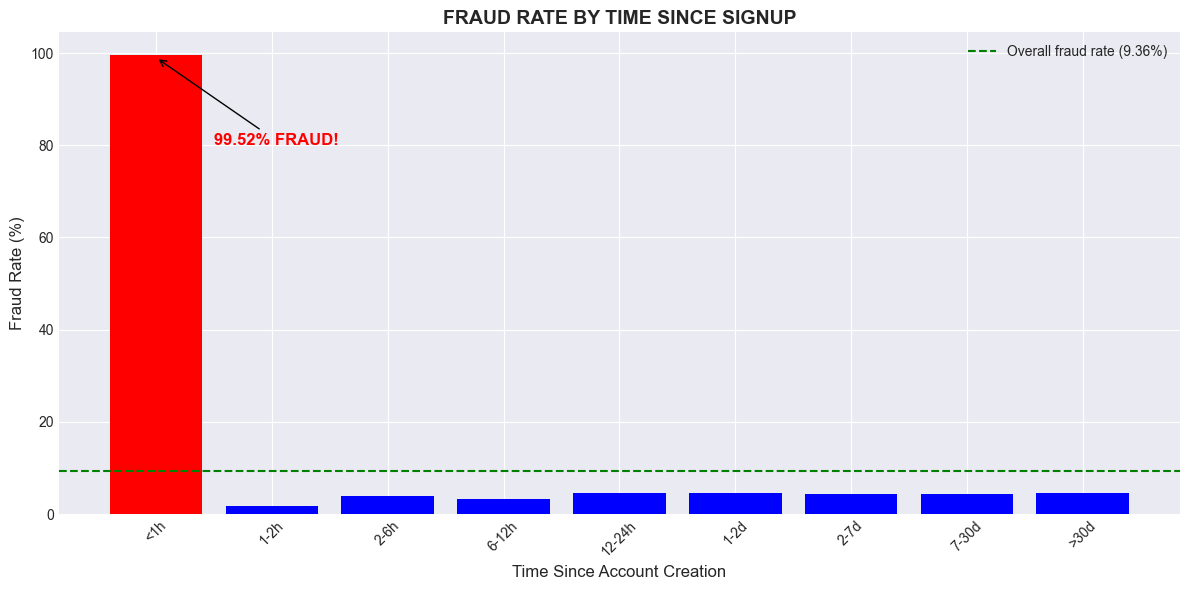

✅ Critical finding visualized and saved!


In [10]:
# Cell 8 Visualize the CRITICAL finding
print("\n=== VISUALIZING KEY FRAUD PATTERN ===")

# Create time bins
fraud_data['time_since_signup_bin'] = pd.cut(
    fraud_data['time_since_signup'], 
    bins=[0, 1, 2, 6, 12, 24, 48, 168, 720, 99999],
    labels=['<1h', '1-2h', '2-6h', '6-12h', '12-24h', '1-2d', '2-7d', '7-30d', '>30d']
)

# Calculate fraud rates
fraud_by_time = fraud_data.groupby('time_since_signup_bin')['class'].mean() * 100

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(fraud_by_time.index.astype(str), fraud_by_time.values, color=['red'] + ['blue']*8)
plt.title('FRAUD RATE BY TIME SINCE SIGNUP', fontsize=14, fontweight='bold')
plt.xlabel('Time Since Account Creation', fontsize=12)
plt.ylabel('Fraud Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.axhline(y=9.36, color='green', linestyle='--', label='Overall fraud rate (9.36%)')
plt.legend()

# Annotate the critical finding
plt.annotate('99.52% FRAUD!', xy=(0, 99), xytext=(0.5, 80),
             arrowprops=dict(facecolor='red', arrowstyle='->'),
             fontsize=12, fontweight='bold', color='red')

plt.tight_layout()
plt.savefig('../data/processed/critical_fraud_pattern.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Critical finding visualized and saved!")